# Moroccan Stocks - Finding the Best Performing Stocks and Price Prediction

#### DijkstraFTW - October 2022

## Imports

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
import statsmodels.api as sm
import seaborn as sns
import itertools
from scipy.stats import *
from collections import Counter
from sklearn.cluster import KMeans
from scipy.stats import gaussian_kde
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, set_link_color_palette
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

We redefine some of the functions that we already used earlier.

In [ ]:
def getData(link) :
  r = requests.get(link)
  return r.json()

In [ ]:
def getSectorInfoData(ISIN) :
    temp = getData("https://medias24.com/content/api?ISIN=" + ISIN +"&format=json&method=getSectorInfo")
    df = pd.DataFrame.from_dict(temp)
    return df

In [ ]:
def getStockHistoryData(ISIN) :
    temp = getData("https://medias24.com/content/api?ISIN=" + ISIN +"&format=json&method=getPriceHistory&from=2017-01-01&to=2022-09-21")
    df = pd.DataFrame.from_dict(temp["result"])
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)
    return df

In [ ]:
todayStocks = getData("https://medias24.com/content/api?method=getAllStocks&format=json")

df_todayStocks = pd.DataFrame.from_dict(todayStocks["result"])
df_todayStocks['datetime'] = pd.to_datetime(df_todayStocks['datetime'], dayfirst=True, errors='coerce')
df_todayStocks.rename(columns={'name': 'name', 'name_2': 'fullName', 'volume_variation' : 'volumeVariation'}, inplace=True)
df_todayStocks.tail()

,name,fullName,ISIN,nbTitre,cours,cloture,cotation,datetime,variation,volumeVariation,volumeTitre,min,max,active
71,Auto Nejma P,AUTO NEJMA,MA0000011009,1 023 264,1817.00,"1 817,00",06/09/2022 à 14:30:52,2022-09-06 14:30:52,-8.14,-147.90,7,1817.00,1817.00,False
72,M2M Group P,M2M GROUPE,MA0000011678,647 777,812.00,"812,00",06/09/2022 à 14:30:52,2022-09-06 14:30:52,0.25,2.03,71,812.00,812.00,False
73,Central.Danone P/N,,MA0000012049,9 420 000,550.00,"550,00",24/06/2022 à 14:30:33,2022-06-24 14:30:33,-0.90,-4.95,259,550.00,550.00,False
74,Rebab Company P,REBAB,MA0000010993,176 456,115.00,"115,00",16/06/2022 à 14:30:35,2022-06-16 14:30:35,0.88,1.01,2,115.00,115.00,False
75,Nexans Maroc P,NEXANS,MA0000011140,2 243 520,189.00,"189,00",09/12/2021 à 09:30:18,2021-12-09 09:30:18,0.00,0.00,5,189.00,189.00,False


## Finding the Best Performing Stocks

We start off by pulling each stock's sector.

In [ ]:
stocks = df_todayStocks['name']

In [ ]:
sectors = {}
for i in range(len(df_todayStocks)) :
  if i in [23, 31, 63] :
    continue
  temp = pd.DataFrame(getSectorInfoData(df_todayStocks['ISIN'][i])["result"]).transpose()
  sectors[df_todayStocks['name'][i]] = temp['name'].to_string().split(' ')[4]

In [ ]:
df_allStocksData = pd.DataFrame()
for i in range(len(df_todayStocks)) :
  temp = pd.DataFrame(getStockHistoryData(df_todayStocks['ISIN'][i]))
  if i == 0 :
    df_allStocksData['date'] = temp['date']
    df_allStocksData = df_allStocksData.replace(np.nan, 0)
  df_allStocksData[df_todayStocks['name'][i]] = temp['value']

df_allStocksData.head()

,date,Alliances P,Colorado P,BCP P,BMCI P,Addoha P,Auto Hall P,Managem P,Med Paper P,Aradei Capital Br,...,IBMaroc.com P,Maghrebail P,S2M P,Maroc Leasing N,Oulmes P,Auto Nejma P,M2M Group P,Central.Danone P/N,Rebab Company P,Nexans Maroc P
0,2017-10-30,261.0,73.73,300.00,880.0,43.50,97.0,1650.0,NaN,405.0,...,127.1,901.0,260.1,NaN,NaN,NaN,NaN,NaN,NaN,144.0
1,2017-10-31,262.9,72.00,300.00,880.0,43.15,98.0,1650.0,NaN,403.9,...,128.0,901.0,265.0,NaN,NaN,NaN,NaN,NaN,NaN,144.0
2,2017-11-01,269.0,72.00,300.05,880.0,43.15,98.4,1697.0,NaN,403.6,...,128.0,901.0,261.5,NaN,NaN,NaN,360.0,NaN,NaN,144.0
3,2017-11-02,265.0,72.00,300.00,880.0,43.17,96.1,1653.0,NaN,404.0,...,129.0,901.0,260.1,NaN,NaN,NaN,362.5,NaN,NaN,144.0
4,2017-11-03,260.0,74.99,304.60,865.0,43.11,96.0,1725.0,NaN,405.0,...,132.0,901.0,269.0,NaN,NaN,2238.0,369.0,NaN,NaN,144.0


Then, we generate daily, monthly and yearly performances dataframes.

In [ ]:
df_allStocksData_Perf_Daily = pd.DataFrame()
df_allStocksData_Perf_Monthly = pd.DataFrame()
df_allStocksData_Perf_Yearly = pd.DataFrame()

df_allStocksData_Perf_Daily['date'] = df_allStocksData['date']

df_allStocksData_Perf_Monthly['date'] = df_allStocksData['date'].dt.strftime('%B - %Y').drop_duplicates()
df_allStocksData_Perf_Monthly['date'] = pd.to_datetime(df_allStocksData_Perf_Monthly['date'])

df_allStocksData_Perf_Yearly['date'] = df_allStocksData['date'].dt.strftime('%Y').drop_duplicates()
df_allStocksData_Perf_Yearly['date'] = pd.to_datetime(df_allStocksData_Perf_Yearly['date'])


for i in range (len(stocks)) :
  df_allStocksData_Perf_Daily[stocks[i]] = (df_allStocksData[stocks[i]]).astype(float).diff()
  df_allStocksData_Perf_Daily[stocks[i]] = df_allStocksData_Perf_Daily[stocks[i]].replace(np.nan, df_allStocksData_Perf_Daily[stocks[i]].mean())

  df_allStocksData_Perf_Monthly[stocks[i]] = (df_allStocksData[stocks[i]]).astype(float).diff()
  df_allStocksData_Perf_Monthly[stocks[i]] = df_allStocksData_Perf_Daily[stocks[i]].replace(np.nan, df_allStocksData_Perf_Monthly[stocks[i]].mean())

  df_allStocksData_Perf_Yearly[stocks[i]] = (df_allStocksData[stocks[i]]).astype(float).diff()
  df_allStocksData_Perf_Yearly[stocks[i]] = df_allStocksData_Perf_Yearly[stocks[i]].replace(np.nan, df_allStocksData_Perf_Yearly[stocks[i]].mean())


for i in range (len(stocks)) :
  df_allStocksData_Perf_Monthly[stocks[i]] = list(df_allStocksData_Perf_Monthly.groupby(list(df_allStocksData_Perf_Monthly['date'].dt.strftime('%B - %Y')))[stocks[i]].sum().pct_change())
  df_allStocksData_Perf_Monthly[stocks[i]].replace([np.inf, -np.inf], np.nan, inplace=True)
  df_allStocksData_Perf_Monthly[stocks[i]] = df_allStocksData_Perf_Monthly[stocks[i]].fillna(df_allStocksData_Perf_Monthly[stocks[i]].mean())

df_allStocksData_Perf_Monthly['date'] = df_allStocksData['date'].dt.strftime('%B - %Y').drop_duplicates()
df_allStocksData_Perf_Monthly.reset_index(drop=True, inplace=True)


for i in range (len(stocks)) :
  df_allStocksData_Perf_Yearly[stocks[i]] = list(df_allStocksData_Perf_Yearly.groupby(list(df_allStocksData_Perf_Yearly['date'].dt.strftime('%Y')))[stocks[i]].sum().pct_change())
  df_allStocksData_Perf_Yearly[stocks[i]].replace([np.inf, -np.inf], np.nan, inplace=True)
  df_allStocksData_Perf_Yearly[stocks[i]] = df_allStocksData_Perf_Yearly[stocks[i]].fillna(df_allStocksData_Perf_Yearly[stocks[i]].mean())

df_allStocksData_Perf_Yearly['date'] = df_allStocksData['date'].dt.strftime('%Y').drop_duplicates()
df_allStocksData_Perf_Yearly.reset_index(drop=True, inplace=True)
df_allStocksData_Perf_Yearly = df_allStocksData_Perf_Yearly.dropna(axis=1)

In [ ]:
df_allStocksData_Perf_YearlyPlus = df_allStocksData_Perf_Yearly.drop('date', axis=1)
df_allStocksData_Perf_MonthlyPlus = df_allStocksData_Perf_Monthly.drop('date', axis=1)
df_allStocksData_Perf_DailyPlus = df_allStocksData_Perf_Daily.drop('date', axis=1)

We plot the repartition of the yearly performances values.

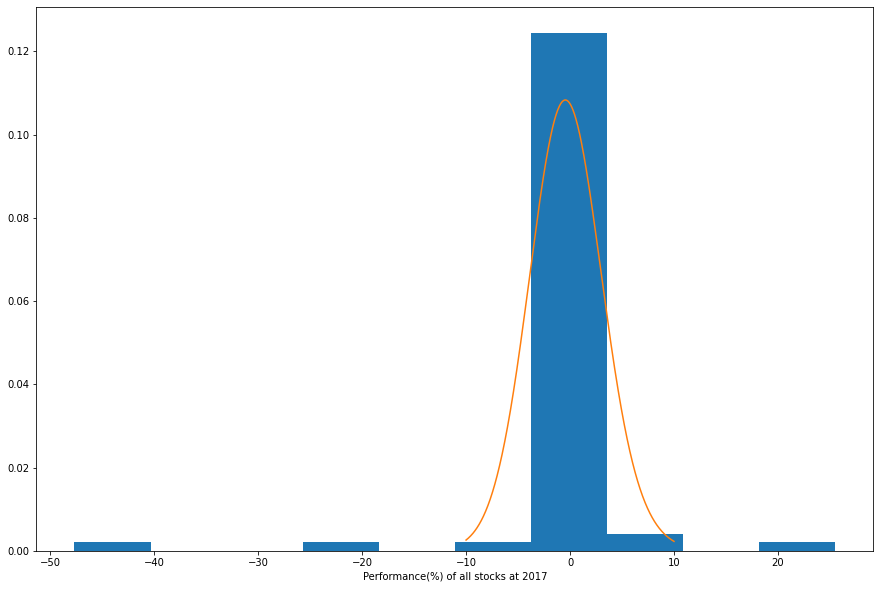

In [ ]:
plt.figure(figsize=(15, 10))
x = np.linspace(-10, 10, 1000)
kde = gaussian_kde(df_allStocksData_Perf_YearlyPlus.iloc[0])
y = kde(x)
plt.hist(df_allStocksData_Perf_YearlyPlus.iloc[0], bins=10, density=True)
plt.plot(x, y)
plt.xlabel(f"Performance(%) of all stocks at {df_allStocksData_Perf_Yearly['date'].iloc[0]}")
plt.show()

A simple altougth naive clustering would be to separate 
the positive and negative performances values.

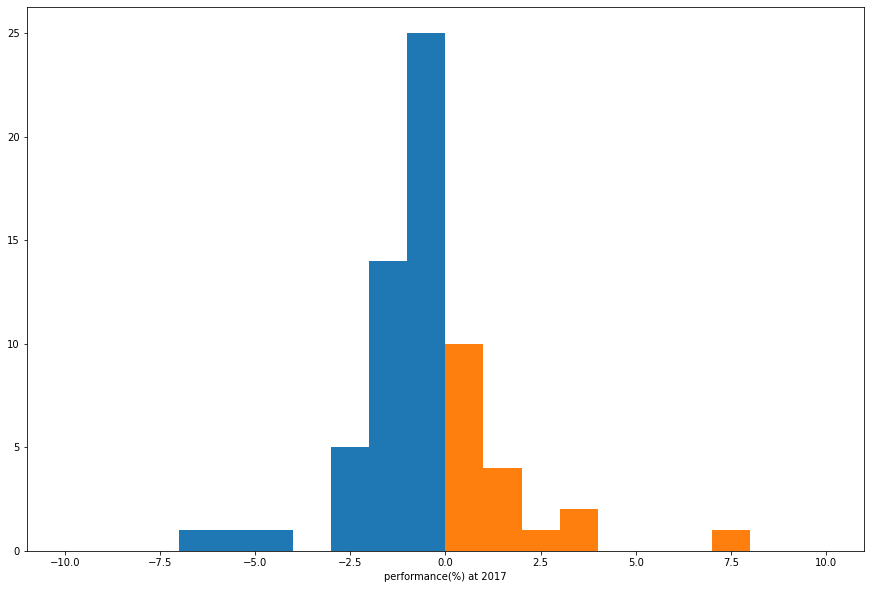

In [ ]:
plt.figure(figsize=(15, 10))
plt.hist(df_allStocksData_Perf_YearlyPlus[df_allStocksData_Perf_YearlyPlus < 0].iloc[-1], range=[-10, 0], bins=10)
plt.hist(df_allStocksData_Perf_YearlyPlus[df_allStocksData_Perf_YearlyPlus >= 0].iloc[-1], range=[0, 10], bins=10)
plt.xlabel(f"performance(%) at {df_allStocksData_Perf_Yearly['date'].iloc[0]}")
plt.show()

We then try to cluster the yearly perfromances values with the K-Means clustering algorithm.

In [ ]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax.scatter(x, y, alpha=0.5)
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

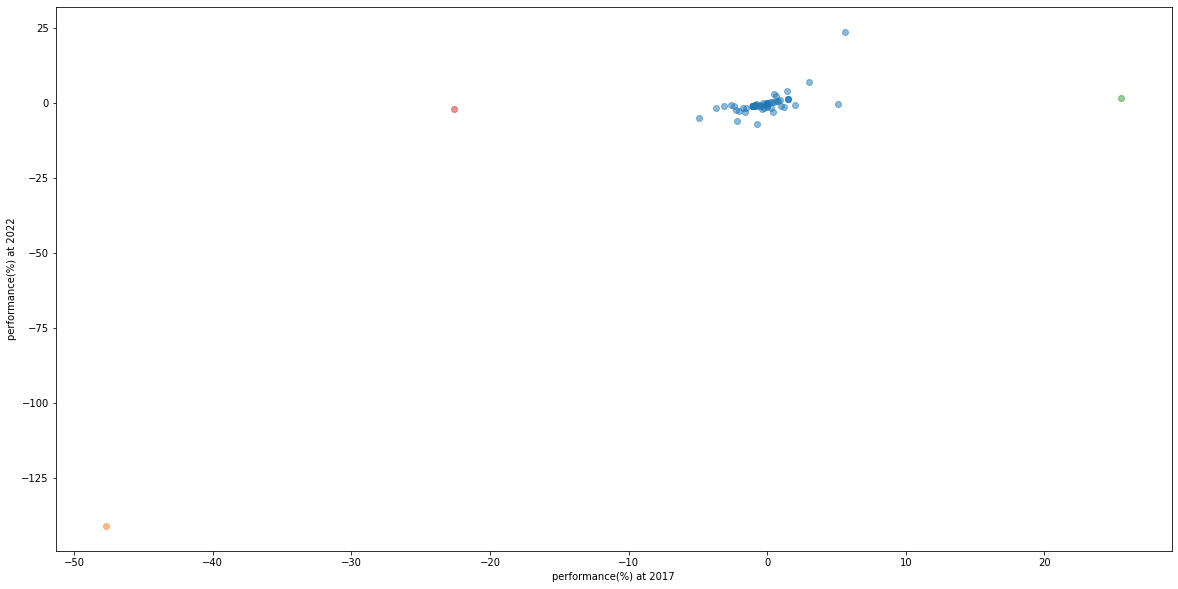

In [ ]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(df_allStocksData_Perf_YearlyPlus.T.values)
plt.figure(figsize=(20, 10))
for i in range(n_clusters):
    plt.scatter(df_allStocksData_Perf_YearlyPlus.iloc[0].loc[kmeans.labels_ == i], df_allStocksData_Perf_YearlyPlus.iloc[-1].loc[kmeans.labels_ == i], alpha=0.5)
plt.xlabel(f"performance(%) at {df_allStocksData_Perf_Yearly['date'].iloc[0]}")
plt.ylabel(f"performance(%) at {df_allStocksData_Perf_Yearly['date'].iloc[-1]}")
plt.show()

The cluster boundaries are clear.

We can also try hierarchical clustering.

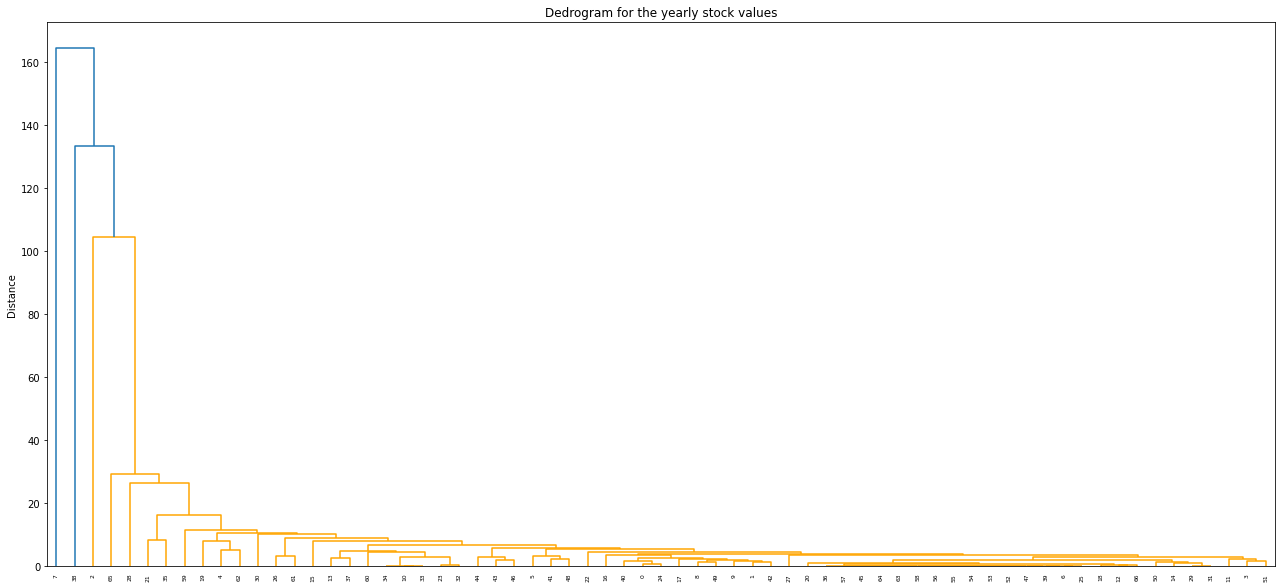

In [ ]:
result = linkage(df_allStocksData_Perf_YearlyPlus.T.values, metric='euclidean', method='average')
color_list = ["orange", "green", "red"]
set_link_color_palette(color_list)
plt.figure(figsize=(22, 10))
dendrogram(result)
plt.title("Dedrogram for the yearly stock values")
plt.ylabel("Distance")
plt.show()

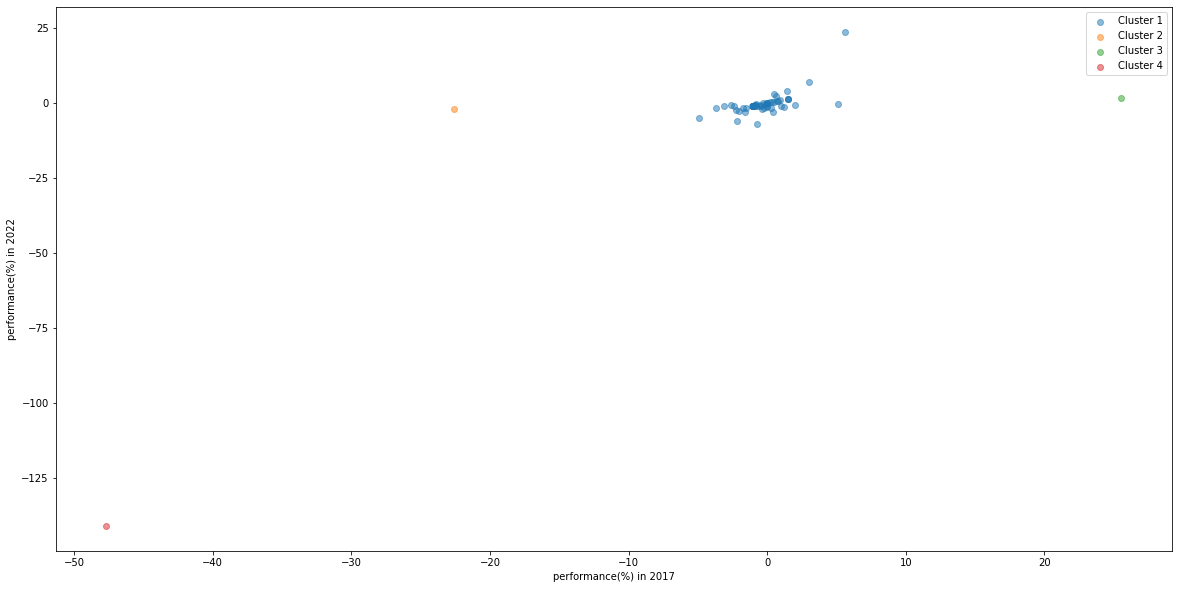

In [ ]:
labels = fcluster(result, t=30, criterion="distance")
plt.figure(figsize=(20, 10))
for i, x in enumerate(set(labels)):
    plt.scatter(df_allStocksData_Perf_YearlyPlus.iloc[0, labels == x],
        df_allStocksData_Perf_YearlyPlus.iloc[-1, labels == x],
        alpha=0.5, label=f"Cluster {x}")
plt.xlabel(f"performance(%) in {df_allStocksData_Perf_Yearly['date'].iloc[0]}")
plt.ylabel(f"performance(%) in {df_allStocksData_Perf_Yearly['date'].iloc[-1]}")
plt.legend()
plt.show()

With hierarchical clustering, the clusters appear to be the same.

We then check which stocks sectors are included in each cluster.

In [ ]:
stock_sectors_yearly = {}
for i in range(len(df_allStocksData_Perf_YearlyPlus.columns)) :
  stock_sectors_yearly[df_allStocksData_Perf_YearlyPlus.columns[i]] = labels[i]
del stock_sectors_yearly['Lydec P']
del stock_sectors_yearly['COSUMAR']
del stock_sectors_yearly['Disty Technolog Br']

d_yearly = {}
for n in set(stock_sectors_yearly.values()):
  d_yearly[n] = [sectors[k] for k in stock_sectors_yearly.keys() if stock_sectors_yearly[k] == n]

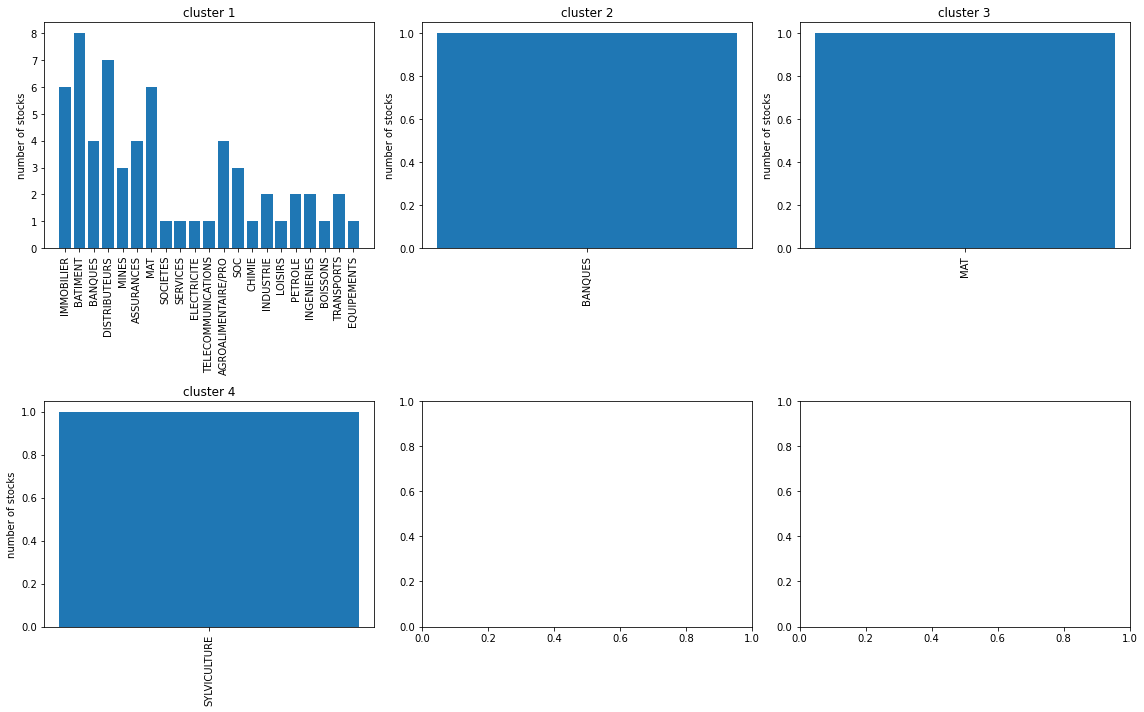

In [ ]:
titles = list(set(labels))
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16, 10))
axes = axes.flatten()
for i, x in enumerate(titles):
    cluster_1 = df_allStocksData_Perf_YearlyPlus.loc[:, labels == x].columns
    axes[i].set_title(f"cluster {x}")
    axes[i].bar(list(Counter(d_yearly[i+1])), dict(Counter(d_yearly[i+1])).values())
    axes[i].tick_params(axis='x', labelrotation=90)
    axes[i].set_ylabel("number of stocks")
fig.tight_layout()
plt.show()

This doesn't really a clear choice for investement, more likely because of the short period covered by our dataset.

We try again with the monthly performance values.

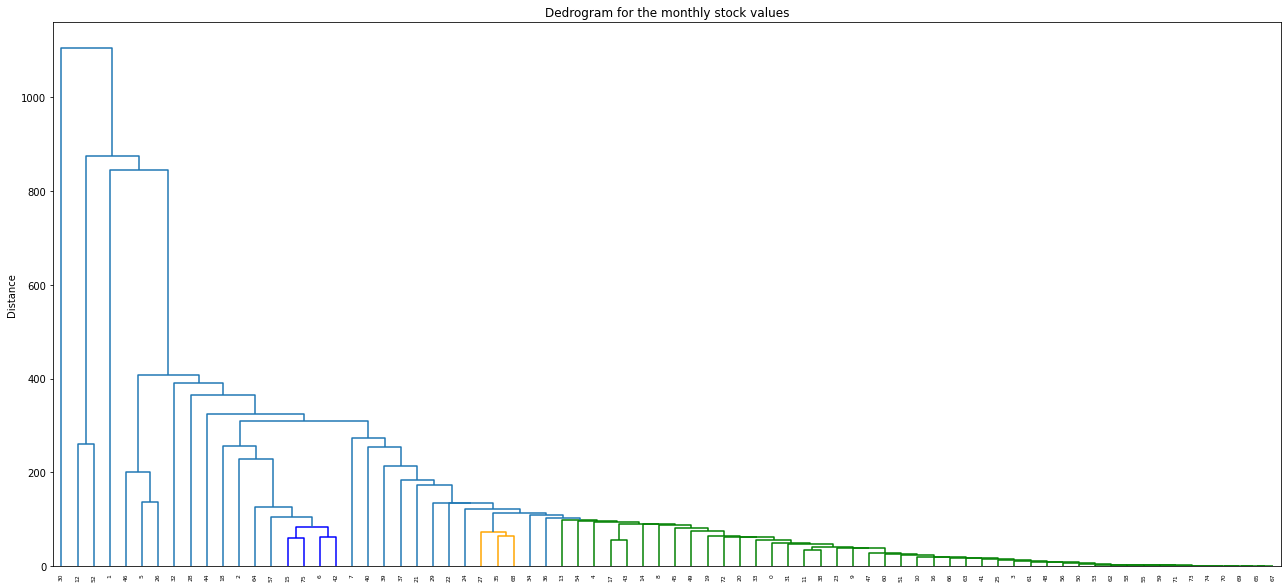

In [ ]:
result = linkage(df_allStocksData_Perf_MonthlyPlus.T.values, metric='euclidean', method='average')
color_list = ["blue", "orange", "green", "red", "grey"]
set_link_color_palette(color_list)
plt.figure(figsize=(22, 10))
dendrogram(result, color_threshold=100)
plt.title("Dedrogram for the monthly stock values")
plt.ylabel("Distance")
plt.show()

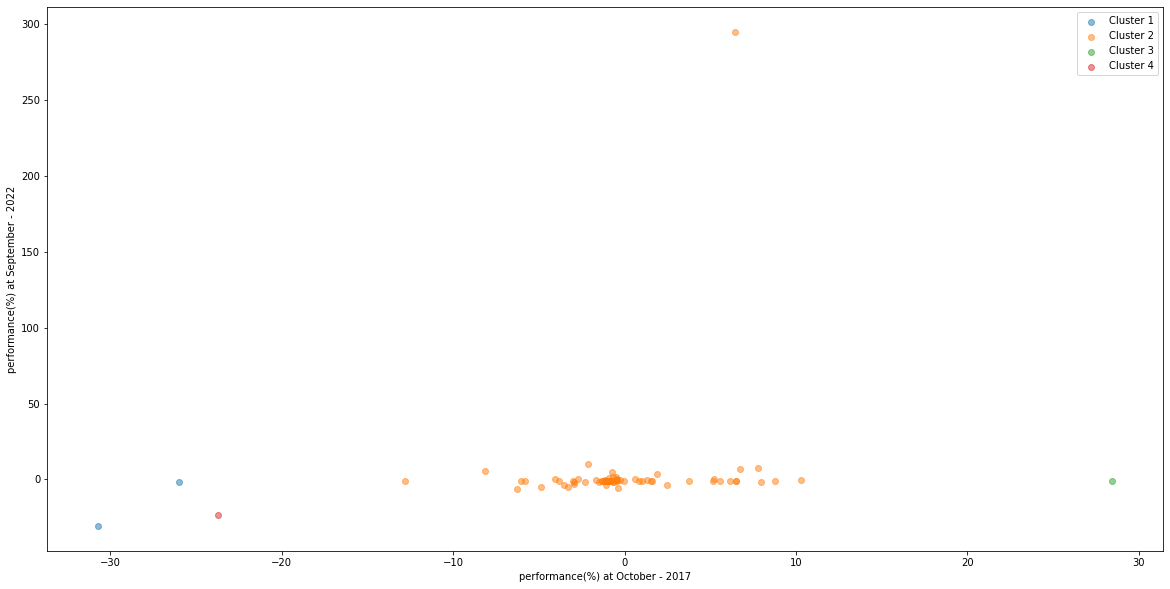

In [ ]:
labels_hierarchical = fcluster(result, t=600, criterion="distance")
plt.figure(figsize=(20, 10))
for i, x in enumerate(set(labels_hierarchical)):
    plt.scatter(df_allStocksData_Perf_MonthlyPlus.loc[0, labels_hierarchical == x],
                df_allStocksData_Perf_MonthlyPlus.iloc[-1, labels_hierarchical == x],
        alpha=0.5, label=f"Cluster {x}")
plt.xlabel(f"performance(%) at {df_allStocksData_Perf_Monthly['date'].iloc[0]}")
plt.ylabel(f"performance(%) at {df_allStocksData_Perf_Monthly['date'].iloc[-1]}")
plt.legend()
plt.show()

We find a different figure as expected.

We can also plot the centroids of each cluster, to better judge their combined monthly performances.

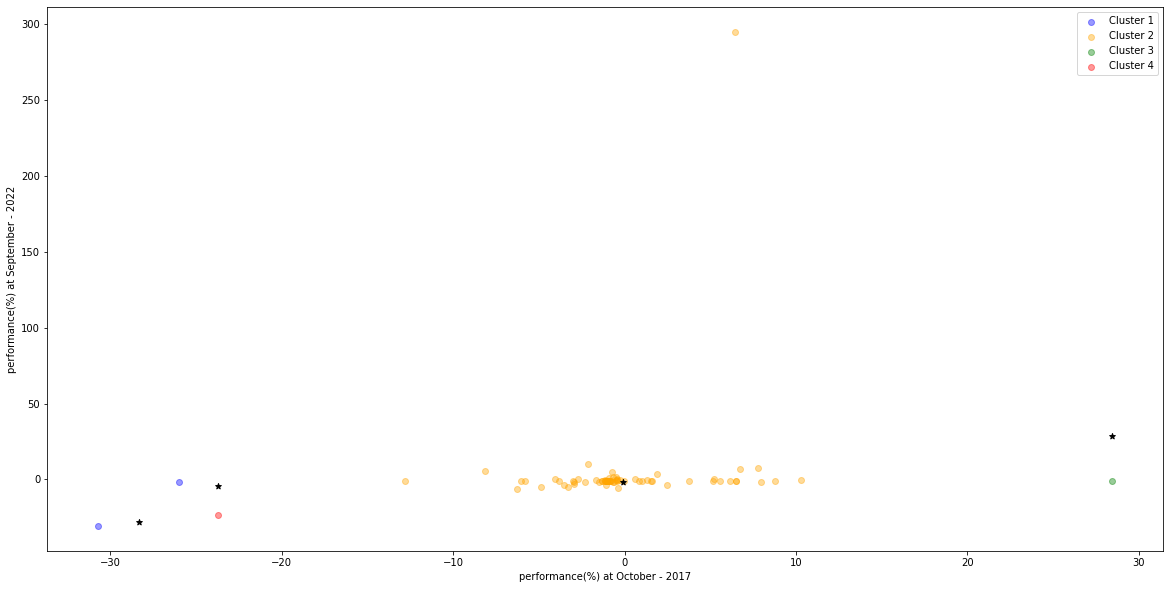

In [ ]:
centroids_list = []
for x in set(labels_hierarchical):
    centroid = df_allStocksData_Perf_MonthlyPlus.loc[:, labels_hierarchical == x].mean(axis=1)
    centroid = pd.DataFrame(centroid, columns=[x])
    centroids_list.append(centroid)
centroids_df = pd.concat(centroids_list, axis=1)
plt.figure(figsize=(20, 10))
for i, x in enumerate(set(labels_hierarchical)):
    plt.scatter(df_allStocksData_Perf_MonthlyPlus.loc[0, labels_hierarchical == x],
                df_allStocksData_Perf_MonthlyPlus.iloc[-1, labels_hierarchical == x],
                alpha=0.4, color=color_list[i], label=f"Cluster {x}")
    plt.scatter(centroids_df.loc[0, x],
    centroids_df.loc[1, x], color="black", marker="*")
plt.xlabel(f"performance(%) at {df_allStocksData_Perf_Monthly['date'].iloc[0]}")
plt.ylabel(f"performance(%) at {df_allStocksData_Perf_Monthly['date'].iloc[-1]}")
plt.legend()
plt.show()

We then check which stocks sectors are included in each cluster.

In [ ]:
stock_sectors_monthly = {}
for i in range(len(df_allStocksData_Perf_MonthlyPlus.columns)) :
  stock_sectors_monthly[df_allStocksData_Perf_MonthlyPlus.columns[i]] = labels_hierarchical[i]
del stock_sectors_monthly['Lydec P']
del stock_sectors_monthly['COSUMAR']
del stock_sectors_monthly['Disty Technolog Br']

d_monthly = {}
for n in set(stock_sectors_monthly.values()):
  d_monthly[n] = [sectors[k] for k in stock_sectors_monthly.keys() if stock_sectors_monthly[k] == n]

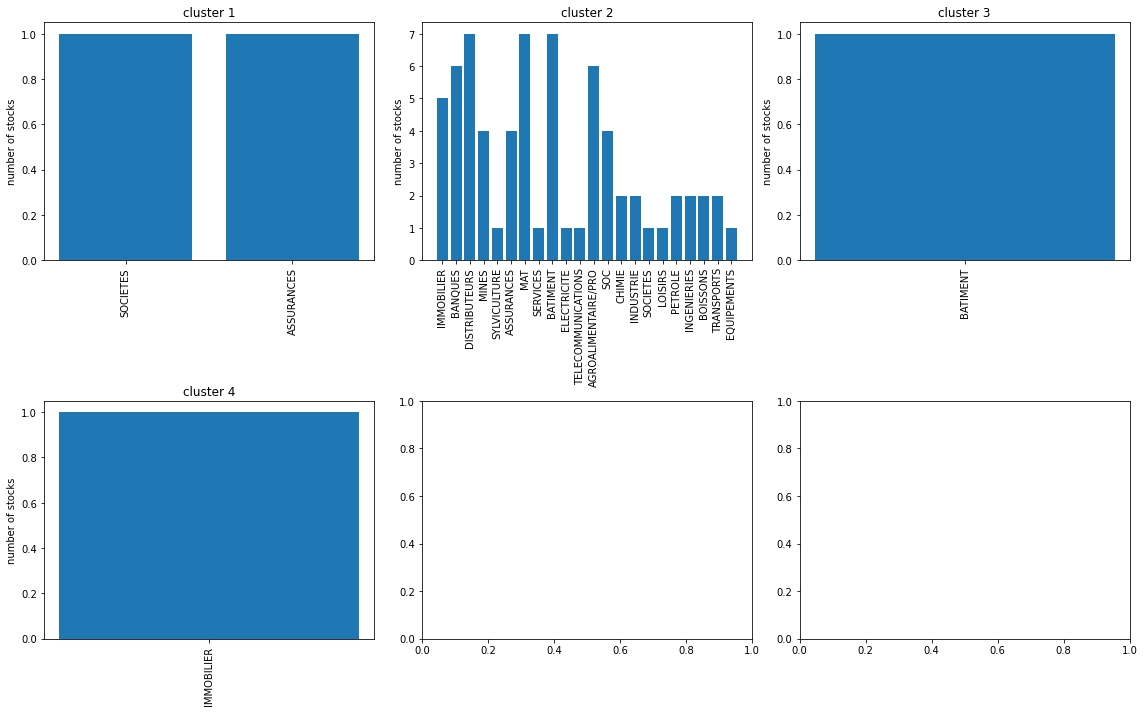

In [ ]:
titles_hierarchical = list(set(labels_hierarchical))
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16, 10))
axes = axes.flatten()
for i, x in enumerate(titles_hierarchical):
    cluster_1 = df_allStocksData_Perf_MonthlyPlus.loc[:, labels_hierarchical == x].columns
    axes[i].set_title(f"cluster {x}")
    axes[i].bar(list(Counter(d_monthly[i+1])), dict(Counter(d_monthly[i+1])).values())
    axes[i].tick_params(axis='x', labelrotation=90)
    axes[i].set_ylabel("number of stocks")
fig.tight_layout()
plt.show()

We can also plot the evolution for each cluster.

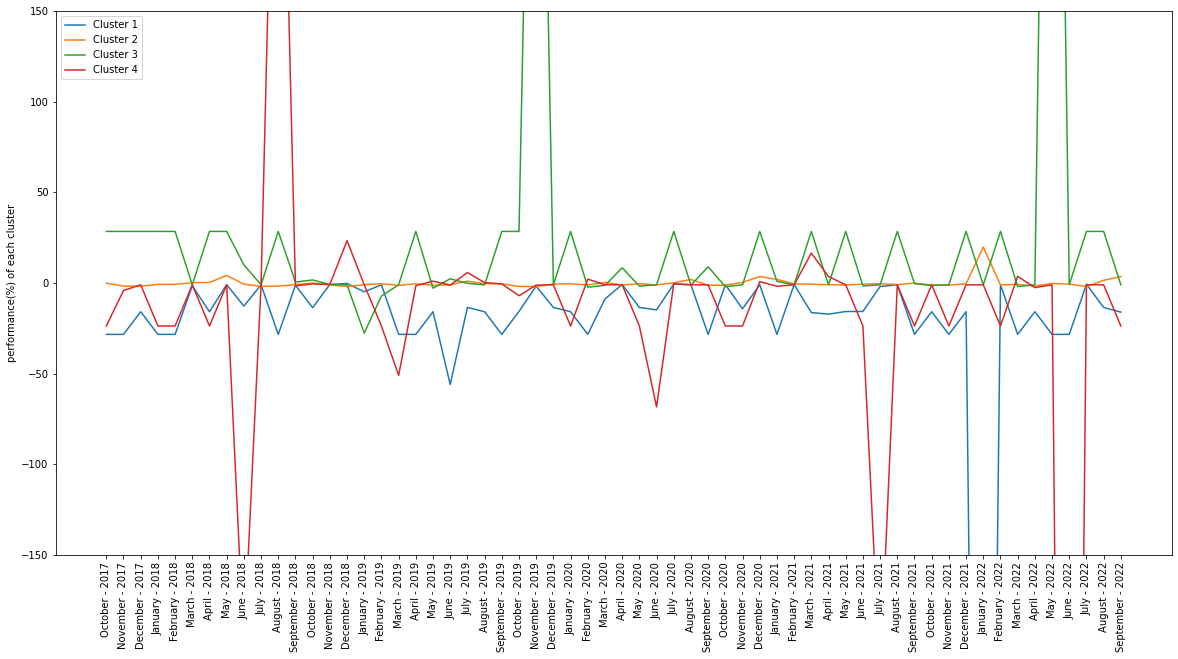

In [ ]:
plt.figure(figsize=(20, 10))
for i, x in enumerate(set(labels_hierarchical)):
    plt.plot(df_allStocksData_Perf_Monthly['date'], centroids_df.loc[:, x], label=f"Cluster {x}")
plt.legend()
plt.xticks(rotation=90)
plt.legend(loc="upper left")
plt.ylim(-150, 150)
plt.ylabel("performance(%) of each cluster")
plt.show()

Plotting the scatterplot matrix to compare each cluster with each other for each month.

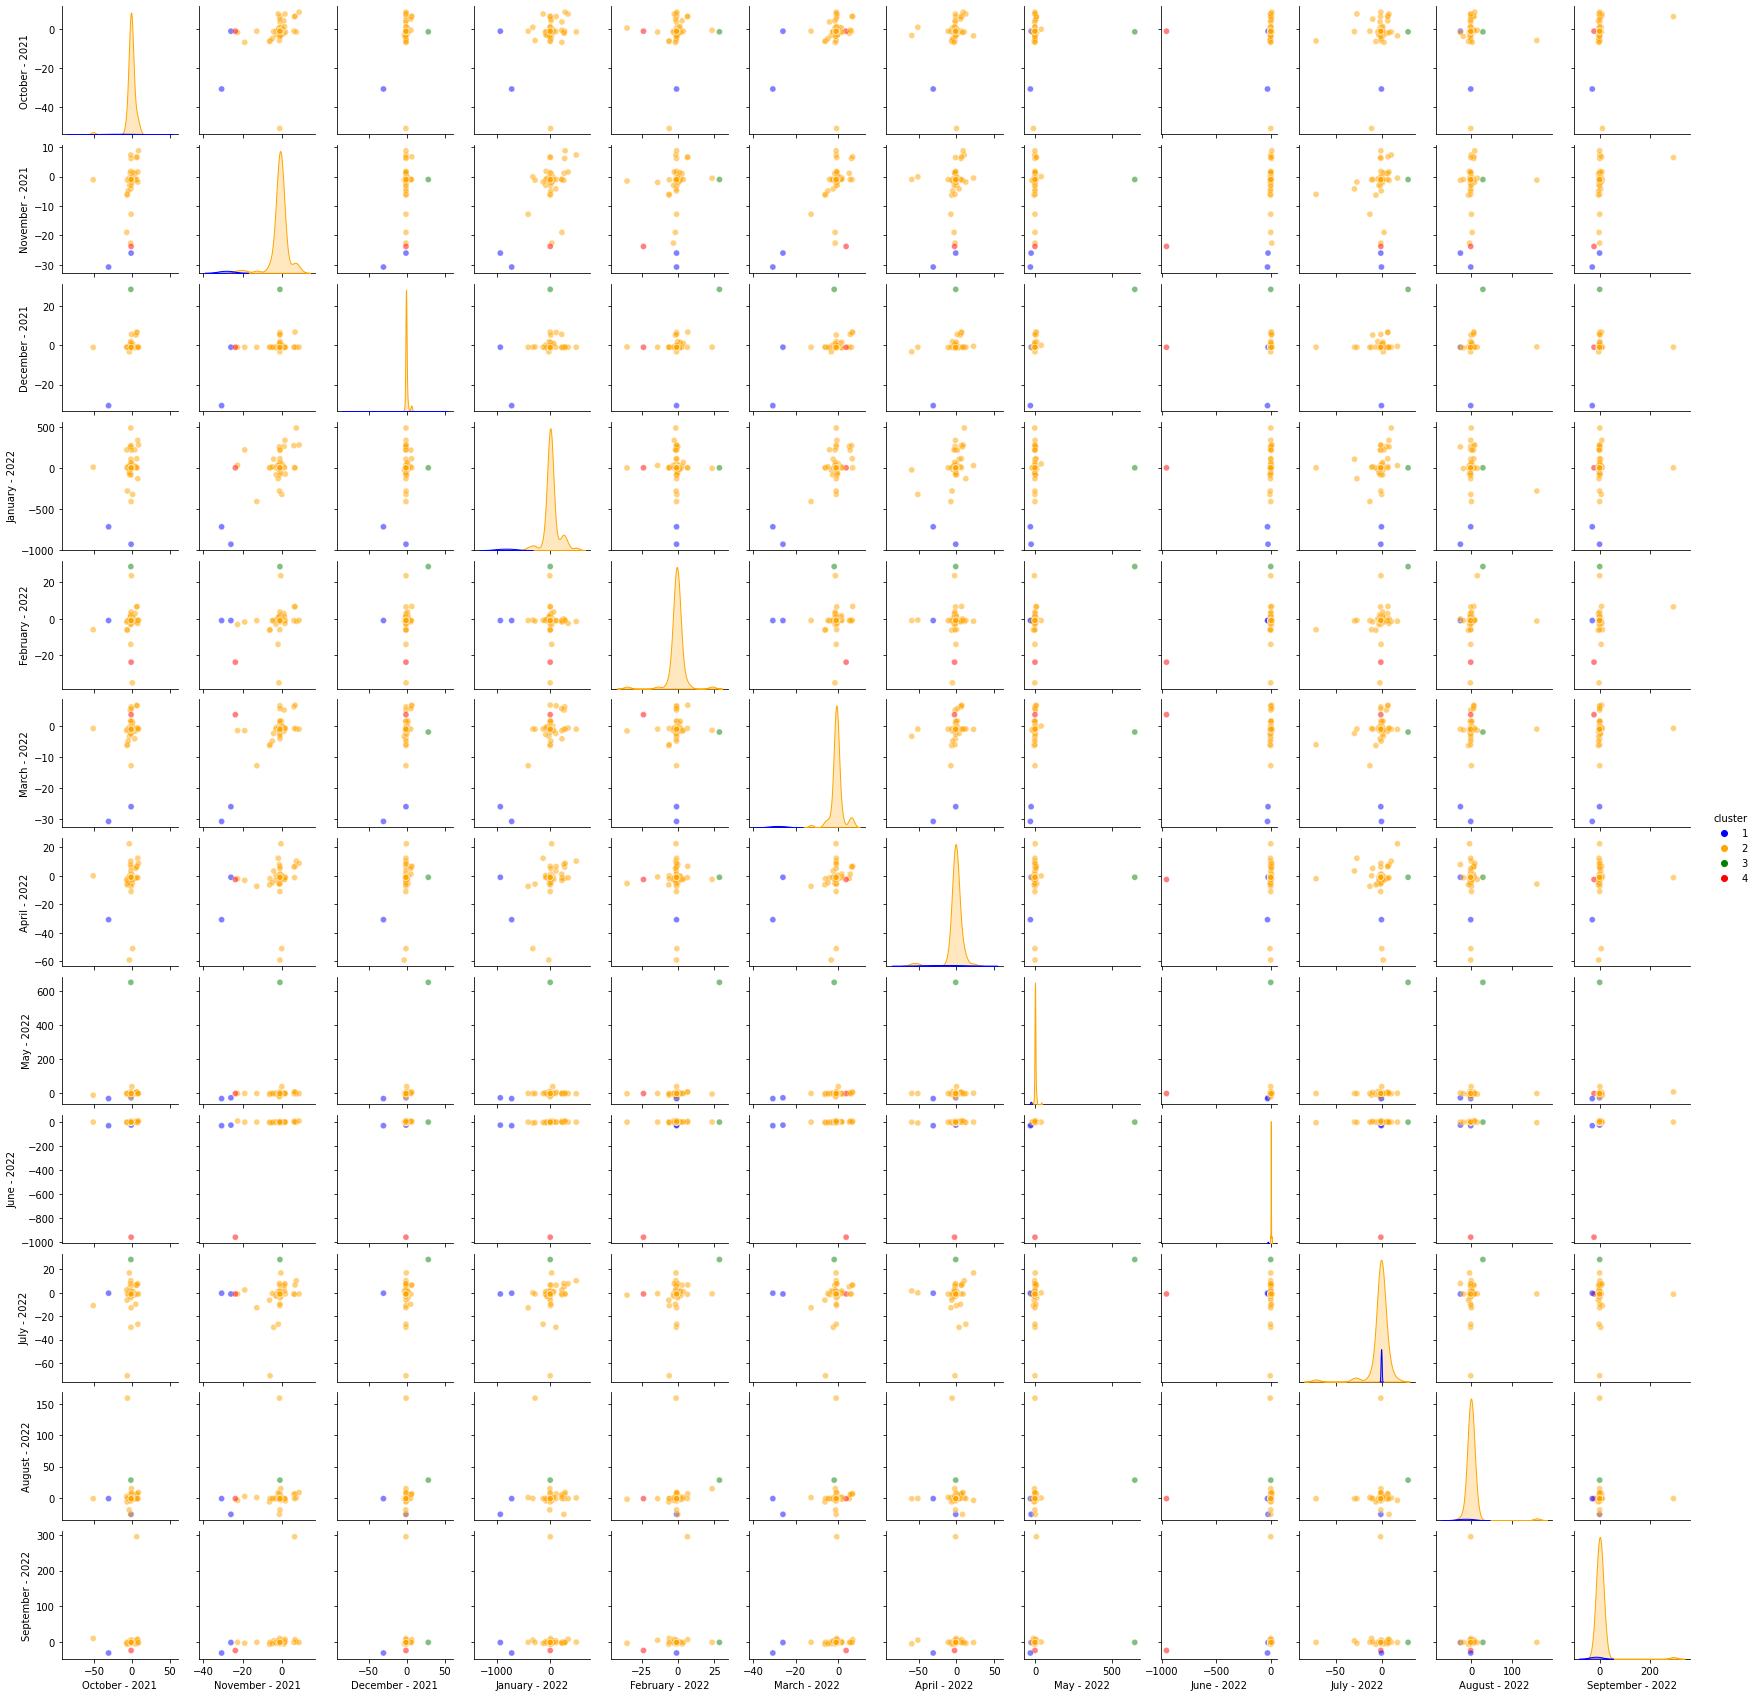

In [ ]:
df_allStocksData_Perf_MonthlyPlus_copy = df_allStocksData_Perf_MonthlyPlus.loc[48:60]
df_allStocksData_Perf_MonthlyPlus_copy = df_allStocksData_Perf_MonthlyPlus_copy.reset_index(drop=True)
df_allStocksData_Perf_MonthlyPlus_copy.index = (list(df_allStocksData_Perf_Monthly['date'].loc[48:60]))
df_allStocksData_Perf_MonthlyPlus_copy = df_allStocksData_Perf_MonthlyPlus_copy.T
labels_str_list = list(map(str, labels_hierarchical))
df_allStocksData_Perf_MonthlyPlus_copy["cluster"] = labels_str_list
sns.pairplot(df_allStocksData_Perf_MonthlyPlus_copy, hue='cluster', height=2, hue_order=sorted(set(labels_str_list)),
             palette=dict(zip(sorted(set(labels_str_list)), color_list)), plot_kws={'alpha': 0.5})
plt.show()

We finally plot all the data of each cluster, to better show that stocks with similar price movements are grouped well.

(-400.0, 400.0)

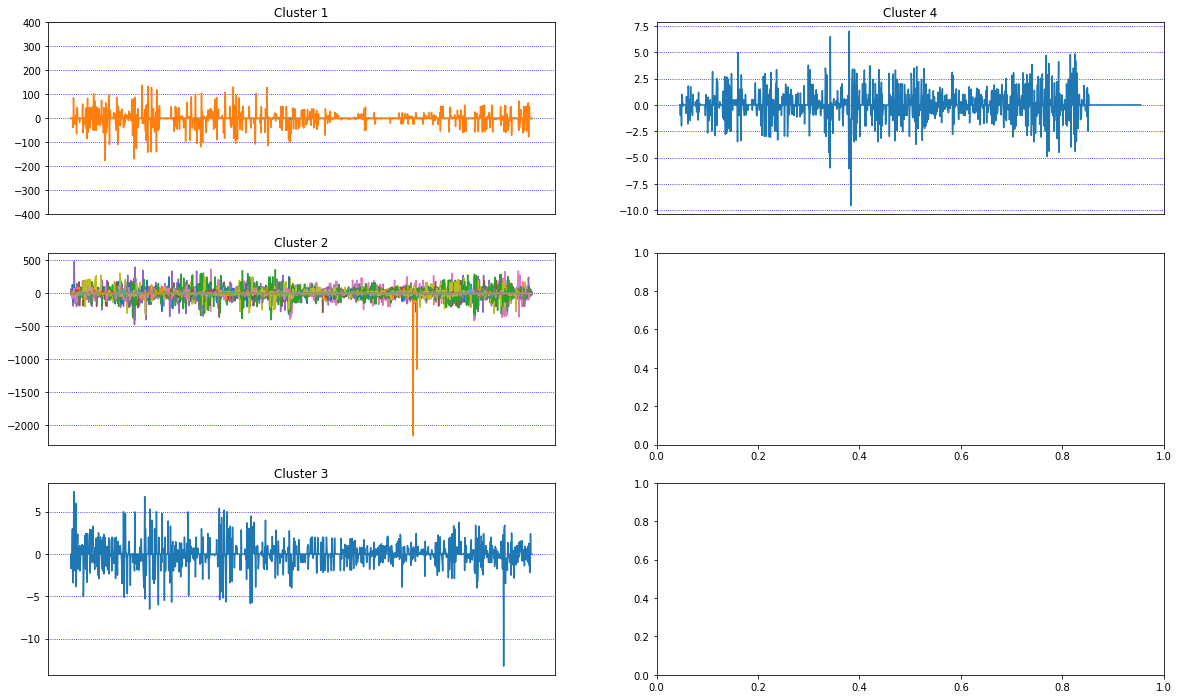

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 12))
for i, x in enumerate(set(labels_hierarchical)):
    ax = axes[i % 3][i // 3]
    if x == -1:
        ax.axis('off')
        continue
    ax.plot(df_allStocksData_Perf_DailyPlus.loc[:, labels_hierarchical == x])
    ax.set_title(f"Cluster {x}")
    ax.get_xaxis().set_visible(False)
    ax.grid(axis='y', linestyle='dotted', color='b')
axes[0][0].set_ylim(-400, 400)

Let's sample stocks from each cluster.

In [ ]:
for x in set(labels_hierarchical):
    if x == 6:
        continue
    print(f"Cluster {x}", end=' ')
    print(list(df_allStocksData_Perf_DailyPlus.loc[:, labels_hierarchical == x].T.sample(min(len(df_allStocksData_Perf_DailyPlus.loc[:, labels_hierarchical == x].T), 5)).index))

Cluster 1 ['Sanlam Maroc N', 'Delta Holding P']
Cluster 2 ['EQDOM P', 'Microdata N', 'FENIE BROSSETTE P', 'INVOLYS P', 'Afric Indus.']
Cluster 3 ['Colorado P']
Cluster 4 ['Immr Invest Br']


# Predicting Future Stock Prices

This section will use IAM's stock data.

In [ ]:
df_historyStockIAM = pd.DataFrame()
df_historyStockIAM = getStockHistoryData("MA0000011488")
df_historyStockIAM.head()

,date,value,min,max,variation,volume
0,2017-10-30,135.55,135.50,136.50,-0.11,42385
1,2017-10-31,135.30,135.30,135.95,-0.18,116190
2,2017-11-01,136.30,135.35,136.30,0.74,124968
3,2017-11-02,136.20,136.05,136.50,-0.07,30484
4,2017-11-03,136.95,136.20,136.95,0.55,212687


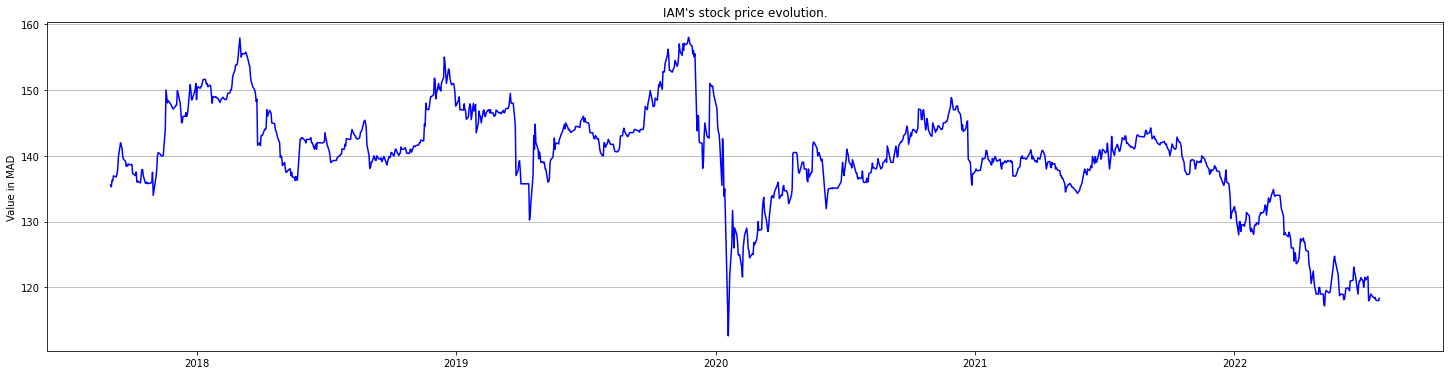

In [ ]:
formatter = mdates.DateFormatter("%Y")
fig = plt.figure(figsize=(20, 5))
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.xticks(rotation=90, fontweight='light',  fontsize='x-small')
plt.tight_layout()
plt.plot(df_historyStockIAM['date'], df_historyStockIAM['value'], color='blue')
plt.ylabel('Value in MAD')
plt.title("IAM's stock price evolution.")
plt.grid(axis="y")
plt.show()

In [ ]:
df_historyStockIAM.index = df_historyStockIAM['date']
temp = pd.DataFrame(df_historyStockIAM['date'])

new_data = df_historyStockIAM.drop({'date', 'min', 'max', 'variation', 'volume'}, axis=1)
new_data.head()

,value
date,
2017-10-30,135.55
2017-10-31,135.30
2017-11-01,136.30
2017-11-02,136.20
2017-11-03,136.95


In [ ]:
df_predictions = pd.DataFrame()
df_predictions["metrics"] = ['MSE', 'RMSE', 'MAPE (%)']
df_predictions = df_predictions.set_index('metrics')

We split our data into a training and testing sets.

In [ ]:
test_ratio = 0.2
training_ratio = 1 - test_ratio
train_size = int(training_ratio * len(df_historyStockIAM))
test_size = int(test_ratio * len(df_historyStockIAM))

train = new_data[:train_size]
test = new_data[train_size:]

print('Shape of training set:')
print(train.shape)

print('\n Shape of test set:')
print(test.shape)

Shape of training set:
(975, 1)

 Shape of test set:
(244, 1)


We scale our data smooth it.

In [ ]:
scaler = MinMaxScaler()
train_data = np.array(train['value']).reshape(-1,1)
test_data = np.array(test['value']).reshape(-1,1)
df_historyStockIAM_normalised = np.array(df_historyStockIAM['value']).reshape(-1,1)
df_historyStockIAM_plot = np.array(df_historyStockIAM['value']).reshape(-1,1)

In [ ]:
smoothing_window_size = 20
for di in range(0, 980, smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

for di in range(0, len(df_historyStockIAM), smoothing_window_size):
    scaler.fit(df_historyStockIAM_normalised[di:di+smoothing_window_size,:])
    df_historyStockIAM_normalised[di:di+smoothing_window_size,:] = scaler.transform(df_historyStockIAM_normalised[di:di+smoothing_window_size,:])

for di in range(0, len(test_data), smoothing_window_size):
    scaler.fit(test_data[di:di+smoothing_window_size,:])
    test_data[di:di+smoothing_window_size,:] = scaler.transform(test_data[di:di+smoothing_window_size,:])

In [ ]:
train_data = train_data.reshape(-1)
df_historyStockIAM_normalised = df_historyStockIAM_normalised.reshape(-1)
test_data = test_data.reshape(-1)

In [ ]:
EMA = 0.0
gamma = 0.1
for ti in range(len(train_data)):
  EMA = gamma * train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

for ti in range(len(df_historyStockIAM_normalised)):
  EMA = gamma * df_historyStockIAM_normalised[ti] + (1-gamma)*EMA
  df_historyStockIAM_normalised[ti] = EMA

all_mid_data = np.concatenate([train_data,test_data],axis=0)
df_historyStockIAM_normalised

array([0.48183137, 0.43364823, 0.40520878, ..., 0.3029142 , 0.27262278,
       0.25481996])

## Evaluation Metrics

Let's define our metrics.

MSE measures the average of the squares of the errors—that is, the average squared difference between the estimated values and the actual value.
$$
MSE=\frac{1}{mn} \sum_{i=1}^m \sum_{j=1}^n (x_{ij}-y_{ij})^2
$$

RMSE is a frequently used measure of the differences between values (sample or population values) predicted by a model or an estimator and the values observed
$$
RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}
$$

In [ ]:
def rmse(error):
    return np.sqrt(np.mean([i ** 2 for i in error]))

MAPE is a measure of prediction accuracy of a forecasting method in statistics. It usually expresses the accuracy as a ratio defined by the formula:
$$
MAPE = \frac {100\%}{n}\sum _{t=1}^{n} \lvert \frac{A_t-F_t}{A_t} \lvert
$$

In [ ]:
def mape(y_true, y_pred): 
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    return np.mean(np.abs((y_true-y_pred) / y_true)) * 100

## Moving Average

### Simple Moving Average (MA)

A SMA is a calculation to analyze data points by creating a series of averages of different subsets of the full data set.
$$
SMA_k=\frac {p_n-k+1+p_n-k+2\cdots +p_n}{k}=\frac {1}{k}\sum _{i=n-k+1}^{n}{p_i}
$$

In [ ]:
window_size = 10
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):
    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)

rmse_MA = rmse(mse_errors)
mape_MA = mape(df_historyStockIAM_normalised[:len(std_avg_predictions)], std_avg_predictions)

df_predictions["MA"] = [0.5*np.mean(mse_errors), rmse_MA, mape_MA]

print('MSE error for standard averaging : %.5f'%(0.5*np.mean(mse_errors)))
print('RMSE error for standard averaging : %.5f'%rmse_MA)
print('MAPE error for standard averaging :', "{:.5f}".format(mape_MA), '%')

MSE error for standard averaging : 0.00123
RMSE error for standard averaging : 0.00383
MAPE error for standard averaging : 13.80033 %


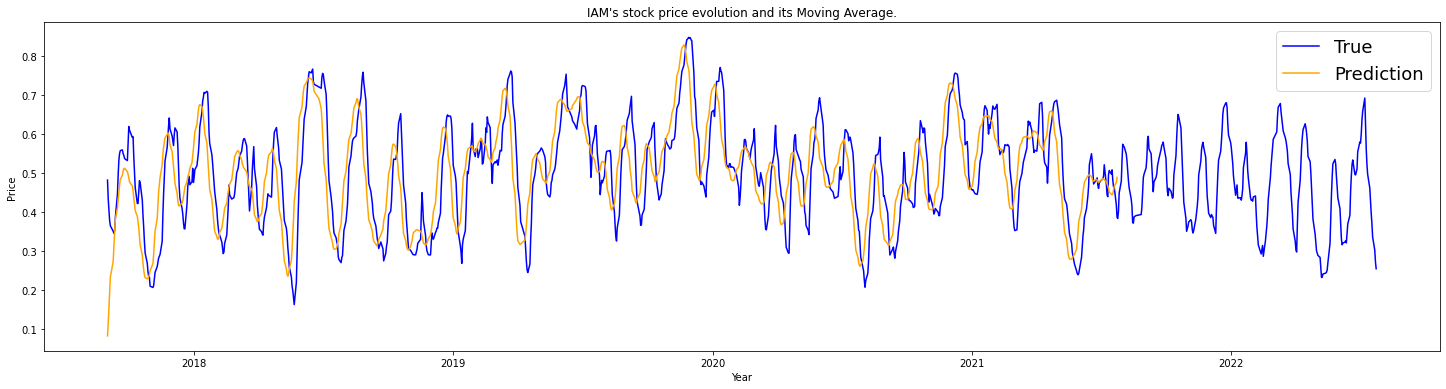

In [ ]:
formatter = mdates.DateFormatter("%Y")
fig = plt.figure(figsize=(20, 5))
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.xticks(rotation=90, fontweight='light',  fontsize='x-small')
plt.tight_layout()
plt.plot(df_historyStockIAM['date'], df_historyStockIAM_normalised, color='b', label='True')
plt.plot(df_historyStockIAM[:len(std_avg_predictions)]['date'], std_avg_predictions, color='orange', label='Prediction')
plt.title("IAM's stock price evolution and its Moving Average.")
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend(fontsize=18)
plt.show()

### Exponential Moving Average (EMA)

Exponential Moving Average (EMA) is similar to Simple Moving Average (SMA), measuring trend direction over a period of time. However, whereas SMA simply calculates an average of price data, EMA applies more weight to data that is more current. Because of its unique calculation, EMA will follow prices more closely than a corresponding SMA.
$$
{\displaystyle S_{t}={\begin{cases}Y_{0},&t=0\\\alpha Y_{t}+(1-\alpha )\cdot S_{t-1},&t>0\end{cases}}}
$$

In [ ]:
window_size = 10
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)

rmse_EMA = rmse(mse_errors)
mape_EMA = mape(df_historyStockIAM_normalised[:len(run_avg_predictions)], run_avg_predictions)

df_predictions["EMA"] = [0.5*np.mean(mse_errors), rmse_EMA, mape_EMA]

print('MSE error for EMA averaging : %.5f'%(0.5*np.mean(mse_errors)))
print('RMSE error for EMA averaging : %.5f'%rmse_EMA)
print('MAPE error for EMA averaging :', "{:.5f}".format(mape_EMA), '%')

MSE error for EMA averaging : 0.00020
RMSE error for EMA averaging : 0.00065
MAPE error for EMA averaging : 21.72237 %


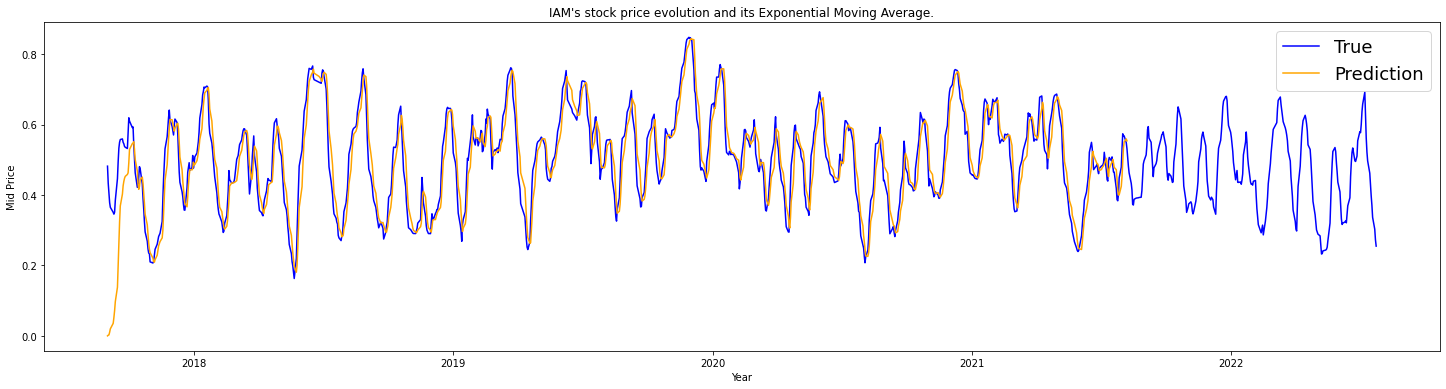

In [ ]:
formatter = mdates.DateFormatter("%Y")
fig = plt.figure(figsize=(20, 5))
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.xticks(rotation=90, fontweight='light',  fontsize='x-small')
plt.tight_layout()
plt.plot(df_historyStockIAM['date'], df_historyStockIAM_normalised,color='b',label='True')
plt.plot(df_historyStockIAM[:len(run_avg_predictions)]['date'], run_avg_predictions, color='orange', label='Prediction')
plt.title("IAM's stock price evolution and its Exponential Moving Average.")
plt.xlabel('Year')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

EMA seems to follow the stock movement better than the MA.

## Long Short-Term Memory (LSTM)

Long short-term memory (LSTM) is an artificial neural network used in the fields of artificial intelligence and deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. Such a recurrent neural network (RNN) can process not only single data points (such as images), but also entire sequences of data (such as speech or video).

In [ ]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)




Unrolled index 0
	Inputs:  [0.00373134 0.70015126 0.75901586 0.73465854 0.6342055 ]

	Output: [0.0512541  0.7301361  0.68116647 0.73465854 0.6134548 ]


Unrolled index 1
	Inputs:  [0.00335821 0.7301361  0.7467506  0.7349023  0.61190647]

	Output: [0.06851675 0.75948715 0.6279589  0.76164544 0.6156443 ]


Unrolled index 2
	Inputs:  [0.01794776 0.7455841  0.68116647 0.758025   0.60305226]

	Output: [0.0512541  0.73414904 0.51474565 0.71214247 0.6156443 ]


Unrolled index 3
	Inputs:  [0.02958582 0.75948715 0.6279589  0.77028704 0.6156443 ]

	Output: [0.12266275 0.72740084 0.4632711  0.76164544 0.6134548 ]


Unrolled index 4
	Inputs:  [0.0512541  0.7566154  0.58879936 0.76164544 0.6134548 ]

	Output: [0.0512541  0.7566154  0.51474565 0.75757766 0.5253359 ]


In [ ]:
D = 1
num_unrollings = 50
batch_size = 500
num_nodes = [200, 200, 150]
n_layers = len(num_nodes)
dropout = 0.2

tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()

In [ ]:
train_inputs, train_outputs = [],[]

for ui in range(num_unrollings):
    train_inputs.append(tf.compat.v1.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.compat.v1.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

In [ ]:
lstm_cells = [
    tf.compat.v1.nn.rnn_cell.LSTMCell(
        num_units=num_nodes[li],
      state_is_tuple=True,
      initializer= tf.initializers.GlorotUniform ()) 
    for li in range(n_layers)
]

drop_lstm_cells = [
    tf.compat.v1.nn.rnn_cell.DropoutWrapper(
        lstm, input_keep_prob=1.0,
        output_keep_prob=1.0-dropout, 
        state_keep_prob=1.0-dropout) 
    for lstm in lstm_cells
]

drop_multi_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(lstm_cells)

w = tf.compat.v1.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.initializers.GlorotUniform ())
b = tf.compat.v1.get_variable('b',initializer=tf.random.uniform([1],-0.1,0.1))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  


In [ ]:
c, h = [], []
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.compat.v1.nn.rnn_cell.LSTMStateTuple(c[li], h[li]))

all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

all_lstm_outputs, state = tf.compat.v1.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.compat.v1.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.compat.v1.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.compat.v1.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.compat.v1.assign(global_step,global_step + 1)
tf_learning_rate = tf.compat.v1.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.compat.v1.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.compat.v1.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

print('TF Optimization operations')
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('All done')


Defining training Loss
Learning rate decay operations
TF Optimization operations
All done


In [ ]:
print('Defining prediction related TF functions')

sample_inputs = tf.compat.v1.placeholder(tf.float32, shape=[1,D])

sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.compat.v1.nn.rnn_cell.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.compat.v1.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.compat.v1.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.compat.v1.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.compat.v1.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.compat.v1.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.compat.v1.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('All done')

Defining prediction related TF functions
All done


In [ ]:
epochs = 30
valid_summary = 1

n_predict_once = 10

train_seq_length = train_data.size

train_mse_ot = []
test_mse_ot = []
predictions_over_time = []

session = tf.compat.v1.InteractiveSession()

tf.compat.v1.global_variables_initializer().run()

loss_nondecrease_count = 0
loss_nondecrease_threshold = 2

print('Initialized')
average_loss = 0

data_gen = DataGeneratorSeq(train_data, batch_size, num_unrollings)

x_axis_seq = []

test_points_seq = np.arange(0, len(df_historyStockIAM) - 1,20).tolist()

for ep in range(epochs):       

    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):

        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))

      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))

      train_mse_ot.append(average_loss)

      average_loss = 0 # reset loss

      predictions_seq = []

      mse_test_loss_seq = []

      # ===================== Updating State and Making Predicitons ========================
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []

        if (ep+1)-valid_summary==0:
          x_axis=[]

        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_mid_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)

        feed_dict = {}

        current_price = all_mid_data[w_i-1]

        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)

        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)

          our_predictions.append(np.asscalar(pred))

          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2

        session.run(reset_sample_states)

        predictions_seq.append(np.array(our_predictions))

        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)

        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)

      current_test_mse = np.mean(mse_test_loss_seq)

      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0

      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')

      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')

print('All done')

Initialized
Average loss at step 1: 7.652713


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


	Test RMSE: 0.15431
	Finished Predictions
Average loss at step 2: 8.011908
	Test RMSE: 0.14254
	Finished Predictions
Average loss at step 3: 7.477977
	Test RMSE: 0.13147
	Finished Predictions
Average loss at step 4: 6.876426
	Test RMSE: 0.12088
	Finished Predictions
Average loss at step 5: 6.126295
	Test RMSE: 0.11057
	Finished Predictions
Average loss at step 6: 5.429318
	Test RMSE: 0.10033
	Finished Predictions
Average loss at step 7: 5.134579
	Test RMSE: 0.09003
	Finished Predictions
Average loss at step 8: 4.576507
	Test RMSE: 0.07955
	Finished Predictions
Average loss at step 9: 3.986136
	Test RMSE: 0.06887
	Finished Predictions
Average loss at step 10: 3.272793
	Test RMSE: 0.05806
	Finished Predictions
Average loss at step 11: 2.700119
	Test RMSE: 0.04732
	Finished Predictions
Average loss at step 12: 1.968345
	Test RMSE: 0.03702
	Finished Predictions
Average loss at step 13: 1.486282
	Test RMSE: 0.02785
	Finished Predictions
Average loss at step 14: 1.085499
	Test RMSE: 0.02091


In [ ]:
rmse_LSTM = rmse(mse_errors)
mape_LSTM = mape(df_historyStockIAM_normalised[:len(predictions_over_time[-1][-1])], predictions_over_time[-1][-1])

df_predictions["LSTM"] = [0.5*np.mean(mse_errors), rmse_LSTM, mape_LSTM]

print('MSE error: %.5f'%(0.5*np.mean(mse_errors)))
print('RMSE error: %.5f'%rmse_LSTM)
print('MAPE error:', "{:.5f}".format(mape_LSTM), '%')

MSE error: 0.00118
RMSE error: 0.00349
MAPE error: 33.88564 %


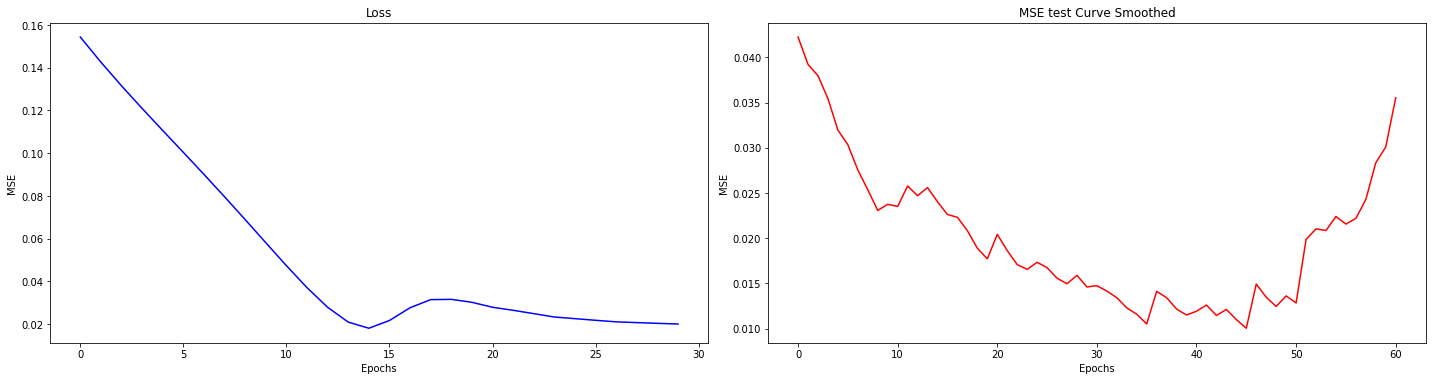

In [ ]:
loss_values = np.concatenate(mse_test_loss_seq).ravel().tolist()
for ti in range(len(loss_values)):
  EMA = gamma * loss_values[ti] + (1-gamma)*EMA
  loss_values[ti] = EMA

plt.figure(figsize = (20,10))

plt.subplot(2,2,2)
plt.plot(range(0, len(loss_values)), loss_values, color='red')
plt.title("MSE test Curve Smoothed")
plt.xlabel('Epochs')
plt.ylabel('MSE')

plt.subplot(2,2,1)

plt.plot(range(0, len(test_mse_ot)), test_mse_ot, color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title("Loss")

plt.tight_layout()
plt.show()

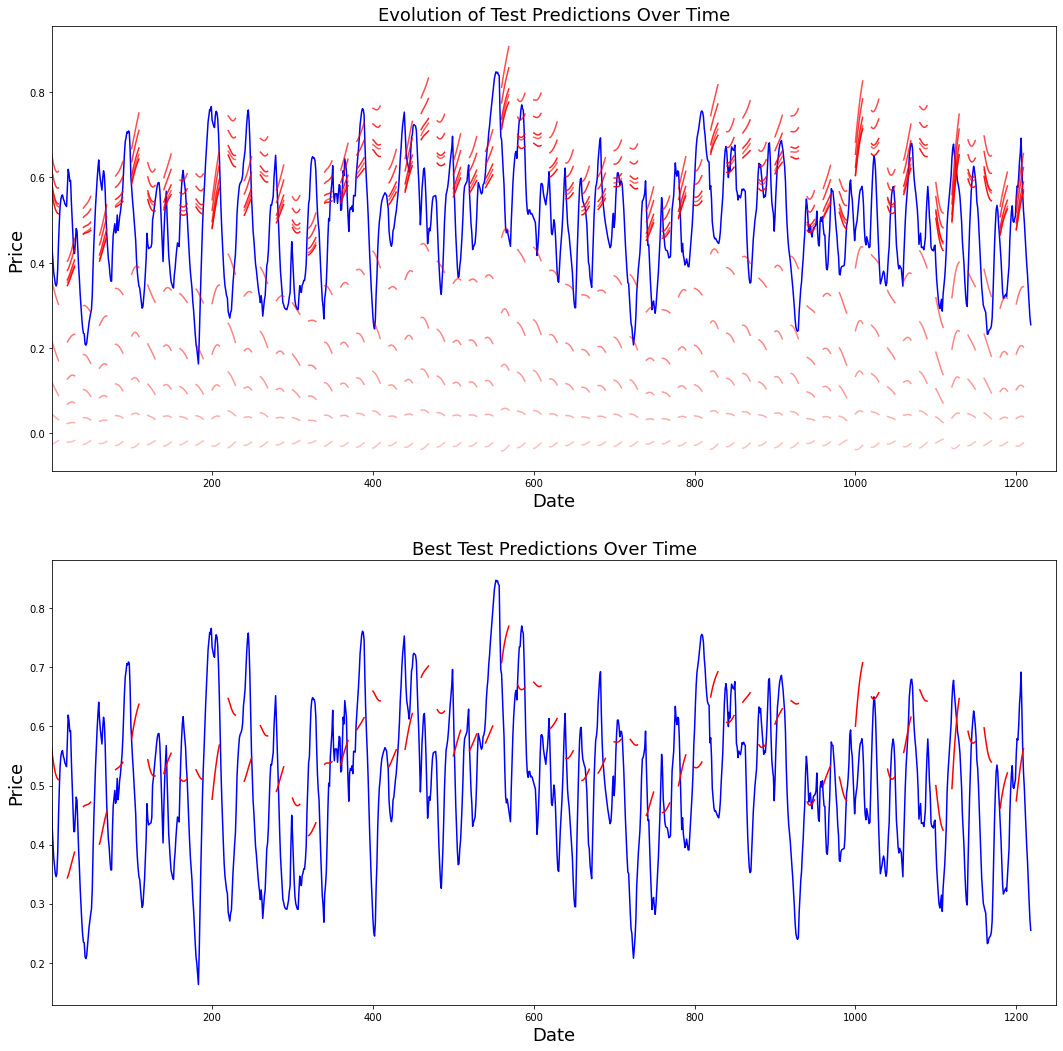

In [ ]:
best_prediction_epoch = 28

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(0, len(df_historyStockIAM_normalised)), df_historyStockIAM_normalised,color='b')

start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval, yval, color='r', alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.xlim(1,1250)

plt.subplot(2,1,2)

plt.plot(range(0, len(df_historyStockIAM_normalised)), df_historyStockIAM_normalised,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval, yval,color='r')

plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.xlim(1,1250)
plt.show()

We can certainly obtain a better prediction by tuning our model's paramaters, which i'm hoping to do in the future.